In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [2]:
#convert the image to batches to solve memory error
path_csv = 'path_to_train.csv'   #complete path to csv data of images 
path_image_train = 'path_to_train_images'  #complete path to training images
data_csv = pd.read_csv(path_csv)

In [4]:
IMG_HEIGHT = 256
IMG_WIDTH = 1600
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [4]:
data_enc = data_csv['EncodedPixels']
data_img_id = list(data_csv['ImageId'])

In [5]:
data_enc.shape

(7095,)

In [6]:
train_img = next(os.walk(path_image_train))[2]    #walk through all images in the path
train_img.index('0a1cade03.jpg')                  #to get the index of an image id

11

In [21]:
x_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
img_with_mask = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [22]:
def rle2mask(rle, imgshape):
    #width & height of steel image
    width = imgshape[0]    
    height= imgshape[1]
    
    #flatttened empty array with size of input image
    mask= np.zeros( width*height ).astype(np.uint8)
    #convert all elements of encoded image pixels to int values
    array = np.asarray([int(x) for x in rle.split()])
    
    #splitting the encoded pixels
    #every odd index of encoded array is the start pixel &
    #every even index of encoded array is the length of the mask from start
    starts = array[0::2]
    lengths = array[1::2]
    
    #expanding the encoded pixel
    #current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 255
        #current_position += lengths[index]
    
    #numpy operations to bring the shape of mask suitable to image
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )


In [23]:
for i, img_id in tqdm(enumerate(train_img), total=len(train_img)):
    path = path_image_train + img_id
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    x_train[i] = img_resize     #store all the train images as numpy arrays for training
    
    #check whether an image has corresponding mask in the csv data or not
    if img_id in data_img_id:
        idx = data_img_id.index(img_id)
        img_resize_1 = np.resize(img, (IMG_HEIGHT,IMG_WIDTH,1))
        y_train[i] = rle2mask(data_enc[idx], img_resize_1.shape)   #store all the masks as numpy arrays for training
        

100%|██████████| 25/25 [00:00<00:00, 86.33it/s]


#### Test

--------------------------------------

In [ ]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50

for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    img = cv2.imread( path_image_train+fn )
    mask = rle2mask( data_csv['EncodedPixels'].iloc[i], img.shape  )
    img[mask==1,0] = 255
    
    plt.imshow(img)
plt.show()

In [37]:
#convert numpy array to image
from PIL import Image
y = Image.fromarray(y_train[1])

In [38]:
x = cv2.imread(path_image_train+'0abfbfc69.jpg')

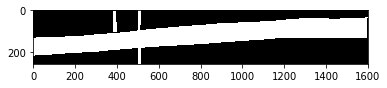

In [40]:
plt.imshow(y)

---------------------------

In [3]:
import tensorflow as tf

C:\Users\Bipin Krishnan P\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
#U-net architecture
inputs = tf.keras.layers.Input(input_shape)

c1 = tf.keras.layers.Conv2D(8, (3,3), activation='elu', padding='same')(inputs)
c2 = tf.keras.layers.Conv2D(8, (3,3), activation='elu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c2 = tf.keras.layers.Conv2D(16, (3,3), activation='elu', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(16, (3,3), activation='elu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c5a = tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same')(p5)
c5a = tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same')(c5a)

u6 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5a)
u6 = tf.keras.layers.concatenate([u6,c5])

c6 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(u6)
c6 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', padding='same')(c6)

u71 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c6)
u71 = tf.keras.layers.concatenate([u71,c4])

c71 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(u71)
c71 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(u71)

u7 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(u71)
u7 = tf.keras.layers.concatenate([u7,c3])

c7 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])

c8 = tf.keras.layers.Conv2D(16, (3,3), activation='elu', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(16, (3,3), activation='elu', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1], axis=3)

c9 = tf.keras.layers.Conv2D(8, (3,3), activation='elu', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(8, (3,3), activation='elu', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 1600, 8) 224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 1600, 8) 584         conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 